
**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points
### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for extracting the HOG features is contained in the second code cell of the IPython notebook (the `get_hog_features` method). This method makes use of SKImage's hog function to extract the HOG features from the vehicle / non-vehicle images.

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

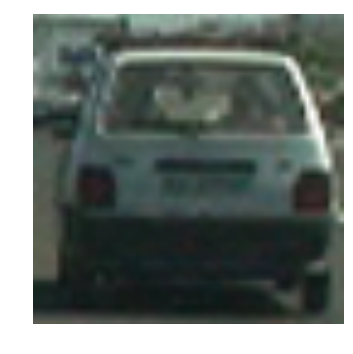

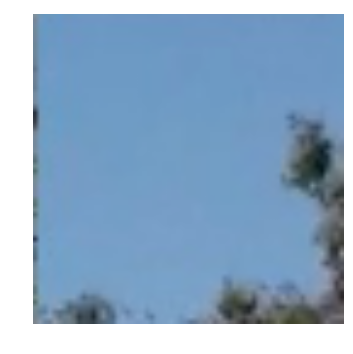

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
vehicle = mpimg.imread("./vehicles/GTI_MiddleClose/image0169.png")
non_vehicle = mpimg.imread("./non-vehicles/Extras/extra1.png")
plt.imshow(vehicle); plt.axis('off'); plt.show()
plt.imshow(non_vehicle); plt.axis('off'); plt.show()

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=9`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


In [33]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

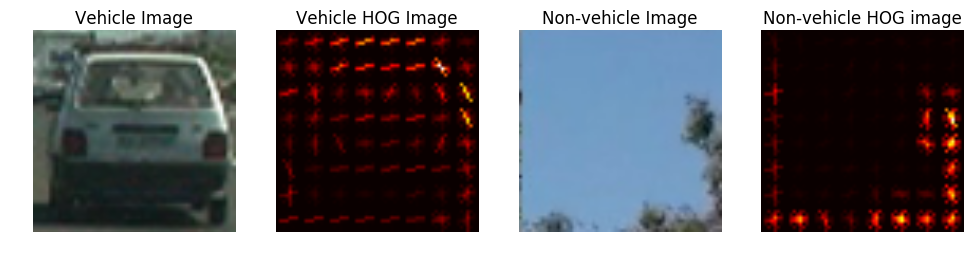

In [36]:
from skimage.feature import hog
import cv2

featimg_vehicle = cv2.cvtColor(vehicle, cv2.COLOR_RGB2YCrCb)
featimg_non_vehicle = cv2.cvtColor(non_vehicle, cv2.COLOR_RGB2YCrCb)

_, hog_img_vehicle = hog(featimg_vehicle[:,:,0], orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualise=True, feature_vector=True)
_, hog_img_non_vehicle = hog(featimg_non_vehicle[:,:,0], orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualise=True, feature_vector=True)

images = [vehicle, hog_img_vehicle, non_vehicle, hog_img_non_vehicle]
titles = ["Vehicle Image", "Vehicle HOG Image", "Non-vehicle Image", "Non-vehicle HOG image"]
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)

#### 2. Explain how you settled on your final choice of HOG parameters.

Using the classroom quizzes as a starting point, I tried and toyed with various combinations of parameters. The CarND Slack-group was also particularly helpful in explaining what parameters would work well and why. <br>
Choosing parameters always involves a toss-up between being too specific and too general. You don't want your vehicle HOG features to be so specific that they won't be able to identify other vehicles, i.e. so that they're overfit to the current example (for example a very high number of orientations). The entire point of HOG is to generalise the features inherent to vehicles, hence one must try to keep generality.

Ultimately, I settled on the basic parameters Ryan suggested, i.e.:
- orientations equal to 9
- 8 pixels per cell
- 2 cells per block

I also combined the hog features from all the colour channels in the YCrCb space, which seemed to work fine. <br>
I would note, however, that processing time was a big constraint. I couldn't test as much as I would've liked, due to processing time for a few seconds of video taking several minutes to process on my dated macbook (an "Intel graphics chip" doesn't count as a graphics card i.m.o.).

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
I used spatial features, the colour histogram of each image, as well as the HOG features to train my models. (See the `extract_features` function) <br>
For classification, I used an ensemble of - firstly - a linear support vector machine (from sklearn - LinearSVC), as well as a very simple feedforward neural network. Using these two classifiers in ensemble produced the best results.

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

The sliding-window search is implemented in the `slide_window` and `search_windows` functions in my the Vehicle Detection iPython notebook. <br> The functions work by sliding a window, or set of windows, across the image being searched (within specific boundaries for where the actual road is in the image). These windows then get fed to the `search_windows` function, which extracts the features (hog, histogram and spatial features) from the image bounded by the window, and feeds them to our classifier(s). We use the result from the classifier to say whether the window in question contains a vehicle or not. <br>

I implemented the sliding window approach at 3 different sizes: 96x96, 128x128 and 192x192.  Smaller window sizes took a lot of time to process, and yielded results that left much to be desired. <br>
Ultimately, I needed to get my window sizes to represent the images I trained on; i.e. a nicely bounded box around most of the vehicles I would like to identify. These three sizes worked well in combination to identify cars at different depths in the camera images. <br>
I kept my overlap at 0,5 - which seemed to work best. I wanted the overlap to be such that it would be unlikely to miss a vehicle (because it might be in the center of two boxes) while not being too inefficient on processing time.

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

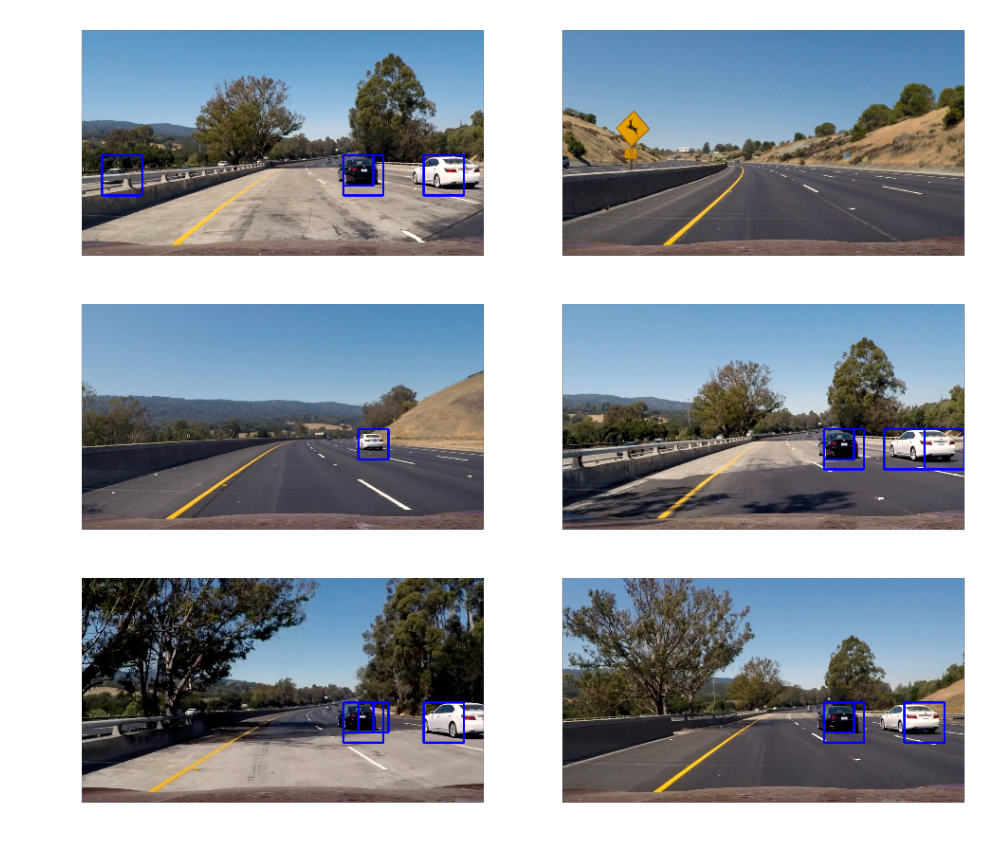

In [40]:
fig = plt.figure(figsize=(12, 18), dpi = 300)
plt.imshow(plt.imread("example_sliding_window_vehicle_technique.png")); plt.axis('off'); plt.show()

---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](./output_video_nn_ensemble.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap, which I averaged over the last 10 frames of the video to get a result (this smooths out unsure, once-off, false positives) and then thresholded that map to identify vehicle positions.  
I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

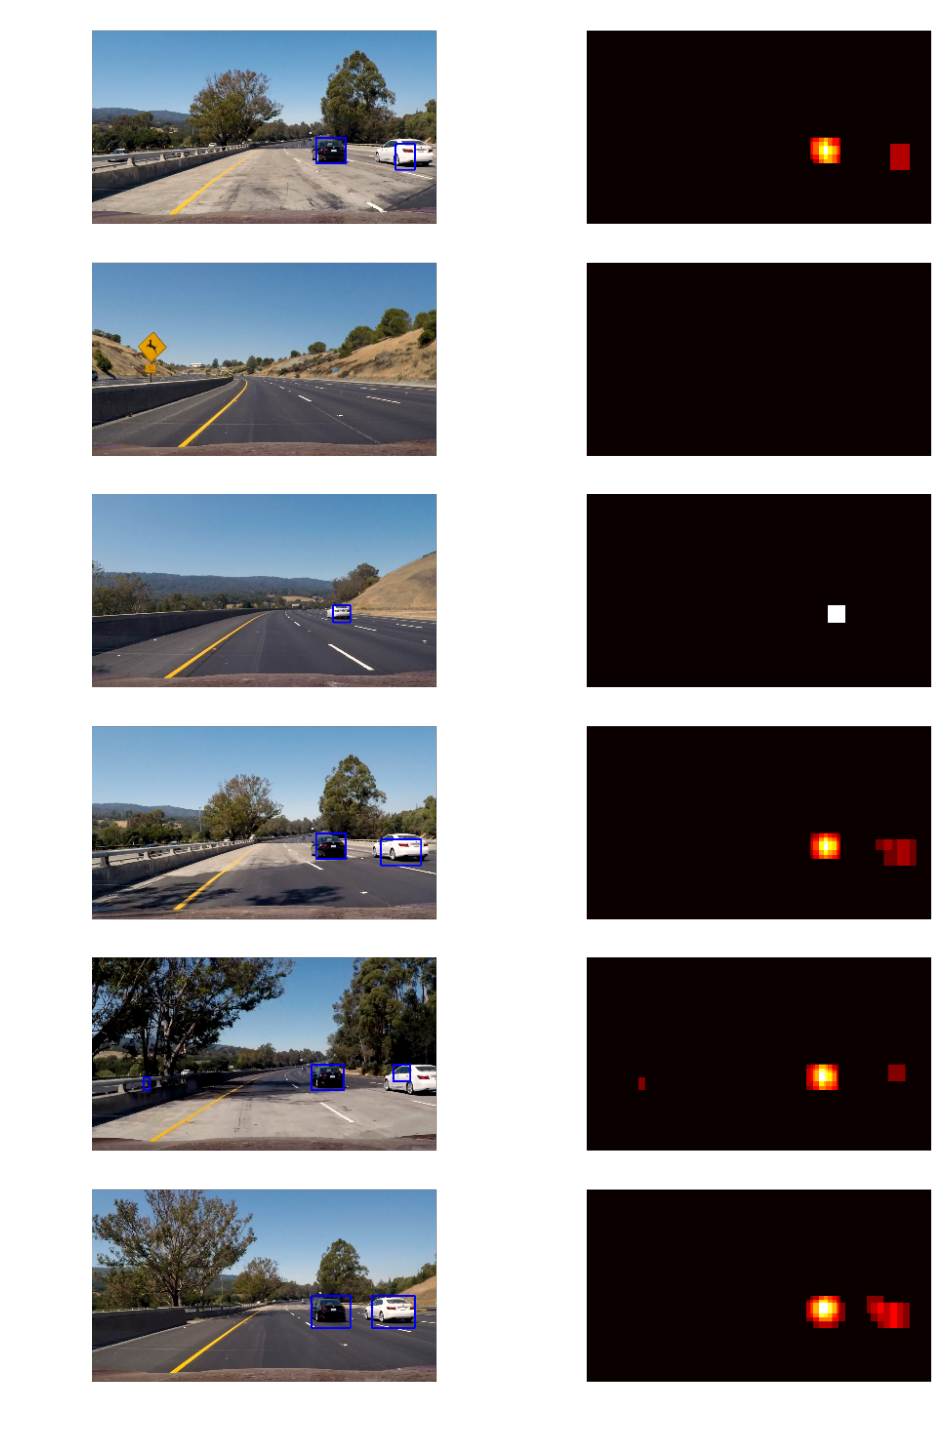

In [42]:
fig = plt.figure(figsize=(12, 18), dpi = 300)
plt.imshow(plt.imread("example_vehicle_detection.png")); plt.axis('off'); plt.show()

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

A major problem for me personally was processing the frames. My computer took ages to process only a mere few seconds of video.  This is very prohibitive for the experimentation process.  I would need to look into being more efficient in my code, in order to improve speed and processing time (or look into better hardware). <br>
Another issue, which makes this project challenging, is the sheer amount of knobs that can be tuned. They can seem overwhelming, and - at first - very daunting to start the tuning process as you try to make the project work.
<br> <br>
The pipeline is likely to fail under very different lighting conditions, or bad weather conditions. We haven't trained enough on images from night driving, and we should expect issues, the same holds for all other sub-ideal weather conditions. <br>
The pipeline could be made more robust by incorporating different models, for example a convolutional neural network fed on the images themselves (not the hog features). Ensembling more models is also an option to consider, as they tend to compliment each other (and add "knowledge").